# Stock Price Prediction - Model Testing

This notebook loads the trained models and tests them on new data.

In [1]:
# Import required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import os
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import warnings
warnings.filterwarnings('ignore')

print("Libraries imported successfully!")

Libraries imported successfully!


In [2]:
# Load the dataset
df = pd.read_csv("/home/kibria/Desktop/IIT_Folders/6th_semester/AI/StockVision/data/processed/all_data.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year

print(f"Dataset shape: {df.shape}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")
print(f"Available years: {sorted(df['year'].unique())}")

Dataset shape: (1791069, 12)
Date range: 2008-03-06 00:00:00 to 2022-12-29 00:00:00
Available years: [np.int32(2008), np.int32(2009), np.int32(2010), np.int32(2011), np.int32(2012), np.int32(2013), np.int32(2014), np.int32(2015), np.int32(2016), np.int32(2017), np.int32(2018), np.int32(2019), np.int32(2020), np.int32(2021), np.int32(2022)]


In [3]:
# Model loading functions
models_dir = "../models"

def load_saved_model(model_name):
    """Load a previously saved model"""
    model_filename = f"{models_dir}/{model_name.replace(' ', '_').lower()}_model.pkl"
    try:
        loaded_model = joblib.load(model_filename)
        print(f"✅ Model '{model_name}' loaded successfully")
        return loaded_model
    except FileNotFoundError:
        print(f"❌ Model file not found: {model_filename}")
        return None

def load_preprocessing_components():
    """Load scaler and feature names"""
    try:
        scaler = joblib.load(f"{models_dir}/feature_scaler.pkl")
        feature_names = joblib.load(f"{models_dir}/feature_names.pkl")
        print("✅ Scaler and feature names loaded successfully")
        return scaler, feature_names
    except FileNotFoundError as e:
        print(f"❌ Preprocessing components not found: {e}")
        return None, None

# Load preprocessing components
scaler, feature_names = load_preprocessing_components()
if feature_names:
    print(f"\nLoaded {len(feature_names)} features: {feature_names[:5]}...")

✅ Scaler and feature names loaded successfully

Loaded 25 features: ['last_traded_price', 'high', 'low', 'opening_price', 'yesterdays_closing_price']...


In [4]:
# Feature engineering function (same as in training)
def create_features(data):
    """Create technical indicators and features for stock prediction"""
    df_features = data.copy()
    
    # Sort by trading_code and date for proper time series features
    df_features = df_features.sort_values(['trading_code', 'date'])
    
    # Technical indicators for each stock
    for code in df_features['trading_code'].unique():
        mask = df_features['trading_code'] == code
        stock_data = df_features[mask].copy()
        
        if len(stock_data) > 1:
            # Price change features
            df_features.loc[mask, 'price_change'] = stock_data['closing_price'].pct_change()
            df_features.loc[mask, 'price_change_abs'] = stock_data['closing_price'].diff()
            
            # Moving averages
            df_features.loc[mask, 'ma_5'] = stock_data['closing_price'].rolling(5).mean()
            df_features.loc[mask, 'ma_10'] = stock_data['closing_price'].rolling(10).mean()
            df_features.loc[mask, 'ma_20'] = stock_data['closing_price'].rolling(20).mean()
            
            # Volatility (rolling standard deviation)
            df_features.loc[mask, 'volatility_5'] = stock_data['closing_price'].rolling(5).std()
            df_features.loc[mask, 'volatility_10'] = stock_data['closing_price'].rolling(10).std()
            
            # Price position relative to high/low
            df_features.loc[mask, 'price_position'] = (stock_data['closing_price'] - stock_data['low']) / (stock_data['high'] - stock_data['low'])
            
            # Lagged features (previous day values)
            df_features.loc[mask, 'prev_close'] = stock_data['closing_price'].shift(1)
            df_features.loc[mask, 'prev_volume'] = stock_data['volume'].shift(1)
            df_features.loc[mask, 'prev_high'] = stock_data['high'].shift(1)
            df_features.loc[mask, 'prev_low'] = stock_data['low'].shift(1)
    
    # Additional features
    df_features['high_low_pct'] = (df_features['high'] - df_features['low']) / df_features['low'] * 100
    df_features['open_close_pct'] = (df_features['closing_price'] - df_features['opening_price']) / df_features['opening_price'] * 100
    
    # Time-based features
    df_features['month'] = df_features['date'].dt.month
    df_features['day_of_week'] = df_features['date'].dt.dayofweek
    df_features['quarter'] = df_features['date'].dt.quarter
    
    return df_features

print("Feature engineering function defined!")

Feature engineering function defined!


In [5]:
# Prepare test data (you can change the year or use different data)
# For demo, let's use 2022 data as test set
test_data = df[df['year'] == 2022].copy()

if test_data.empty:
    print("No 2022 data found. Using last year available for testing.")
    latest_year = df['year'].max()
    test_data = df[df['year'] == latest_year].sample(n=1000, random_state=42)  # Sample for testing
    print(f"Using {latest_year} data sample for testing")

print(f"Test data shape: {test_data.shape}")
print(f"Test data date range: {test_data['date'].min()} to {test_data['date'].max()}")

# Apply feature engineering
test_features = create_features(test_data)
print(f"Test data with features shape: {test_features.shape}")

Test data shape: (112714, 12)
Test data date range: 2022-01-02 00:00:00 to 2022-12-29 00:00:00
Test data with features shape: (112714, 29)


In [6]:
# Prepare test data for prediction
def prepare_test_data(test_df, feature_names, scaler, target_col='closing_price'):
    """Prepare test data for prediction"""
    
    # Remove rows with NaN values
    test_clean = test_df.dropna()
    
    # Prepare feature matrix and target
    X_test = test_clean[feature_names].copy()
    y_test = test_clean[target_col].copy()
    
    # Handle infinity values
    X_test = X_test.replace([np.inf, -np.inf], np.nan)
    
    # Fill remaining NaN values with median
    X_test = X_test.fillna(X_test.median())
    
    # Remove any remaining NaN or inf values
    test_mask = np.isfinite(X_test).all(axis=1) & np.isfinite(y_test)
    X_test = X_test[test_mask]
    y_test = y_test[test_mask]
    
    # Scale features using the saved scaler
    X_test_scaled = scaler.transform(X_test)
    
    print(f"Test samples: {X_test_scaled.shape[0]}")
    print(f"Number of features: {X_test_scaled.shape[1]}")
    
    return X_test_scaled, y_test, test_clean[test_mask]

# Prepare the test data
if scaler is not None and feature_names is not None:
    X_test, y_test, test_info = prepare_test_data(test_features, feature_names, scaler)
    
    print(f"\nTest target statistics:")
    print(f"Min: {y_test.min():.2f}, Max: {y_test.max():.2f}, Mean: {y_test.mean():.2f}")
else:
    print("Cannot prepare test data - missing scaler or feature names")

Test samples: 66735
Number of features: 25

Test target statistics:
Min: 3.80, Max: 5976.10, Mean: 137.88


In [7]:
# Load and test all available models
model_names = [
    'Linear Regression',
    'Ridge Regression', 
    'Random Forest',
    'Gradient Boosting',
    'Decision Tree',
    'K-Nearest Neighbors'
]

test_results = []

print("Testing saved models...\n")

for model_name in model_names:
    print(f"--- Testing {model_name} ---")
    
    # Load the model
    model = load_saved_model(model_name)
    
    if model is not None and 'X_test' in locals() and 'y_test' in locals():
        try:
            # Make predictions
            y_pred = model.predict(X_test)
            
            # Calculate metrics
            mse = mean_squared_error(y_test, y_pred)
            mae = mean_absolute_error(y_test, y_pred)
            r2 = r2_score(y_test, y_pred)
            
            # Store results
            test_results.append({
                'Model': model_name,
                'MSE': mse,
                'MAE': mae,
                'R²': r2,
                'Predictions': y_pred
            })
            
            print(f"MSE: {mse:.2f}")
            print(f"MAE: {mae:.2f}")
            print(f"R²: {r2:.4f}")
            
        except Exception as e:
            print(f"Error testing {model_name}: {str(e)}")
    else:
        print(f"Skipped - model or test data not available")
    
    print()

print(f"Successfully tested {len(test_results)} models!")

Testing saved models...

--- Testing Linear Regression ---
✅ Model 'Linear Regression' loaded successfully
MSE: 0.00
MAE: 0.00
R²: 1.0000

--- Testing Ridge Regression ---
✅ Model 'Ridge Regression' loaded successfully
MSE: 7.77
MAE: 1.66
R²: 1.0000

--- Testing Random Forest ---
✅ Model 'Random Forest' loaded successfully
MSE: 1.46
MAE: 0.16
R²: 1.0000

--- Testing Gradient Boosting ---
✅ Model 'Gradient Boosting' loaded successfully
MSE: 46.47
MAE: 2.65
R²: 0.9997

--- Testing Decision Tree ---
✅ Model 'Decision Tree' loaded successfully
MSE: 7.02
MAE: 0.32
R²: 1.0000

--- Testing K-Nearest Neighbors ---
✅ Model 'K-Nearest Neighbors' loaded successfully
MSE: 356.89
MAE: 4.76
R²: 0.9979

Successfully tested 6 models!


In [8]:
# Compare model performance
if test_results:
    # Create comparison DataFrame
    comparison_df = pd.DataFrame(test_results)
    comparison_df = comparison_df.sort_values('R²', ascending=False)
    
    print("MODEL PERFORMANCE COMPARISON ON TEST DATA")
    print("=" * 50)
    print(comparison_df[['Model', 'MSE', 'MAE', 'R²']].to_string(index=False))
    
    # Best model
    best_model_name = comparison_df.iloc[0]['Model']
    best_r2 = comparison_df.iloc[0]['R²']
    print(f"\n🏆 Best performing model: {best_model_name} (R² = {best_r2:.4f})")
else:
    print("No models were successfully tested.")

MODEL PERFORMANCE COMPARISON ON TEST DATA
              Model          MSE          MAE       R²
  Linear Regression 1.022938e-22 8.629230e-12 1.000000
      Random Forest 1.456787e+00 1.613065e-01 0.999991
      Decision Tree 7.020796e+00 3.157283e-01 0.999958
   Ridge Regression 7.768866e+00 1.659488e+00 0.999954
  Gradient Boosting 4.646586e+01 2.654147e+00 0.999724
K-Nearest Neighbors 3.568926e+02 4.762558e+00 0.997877

🏆 Best performing model: Linear Regression (R² = 1.0000)


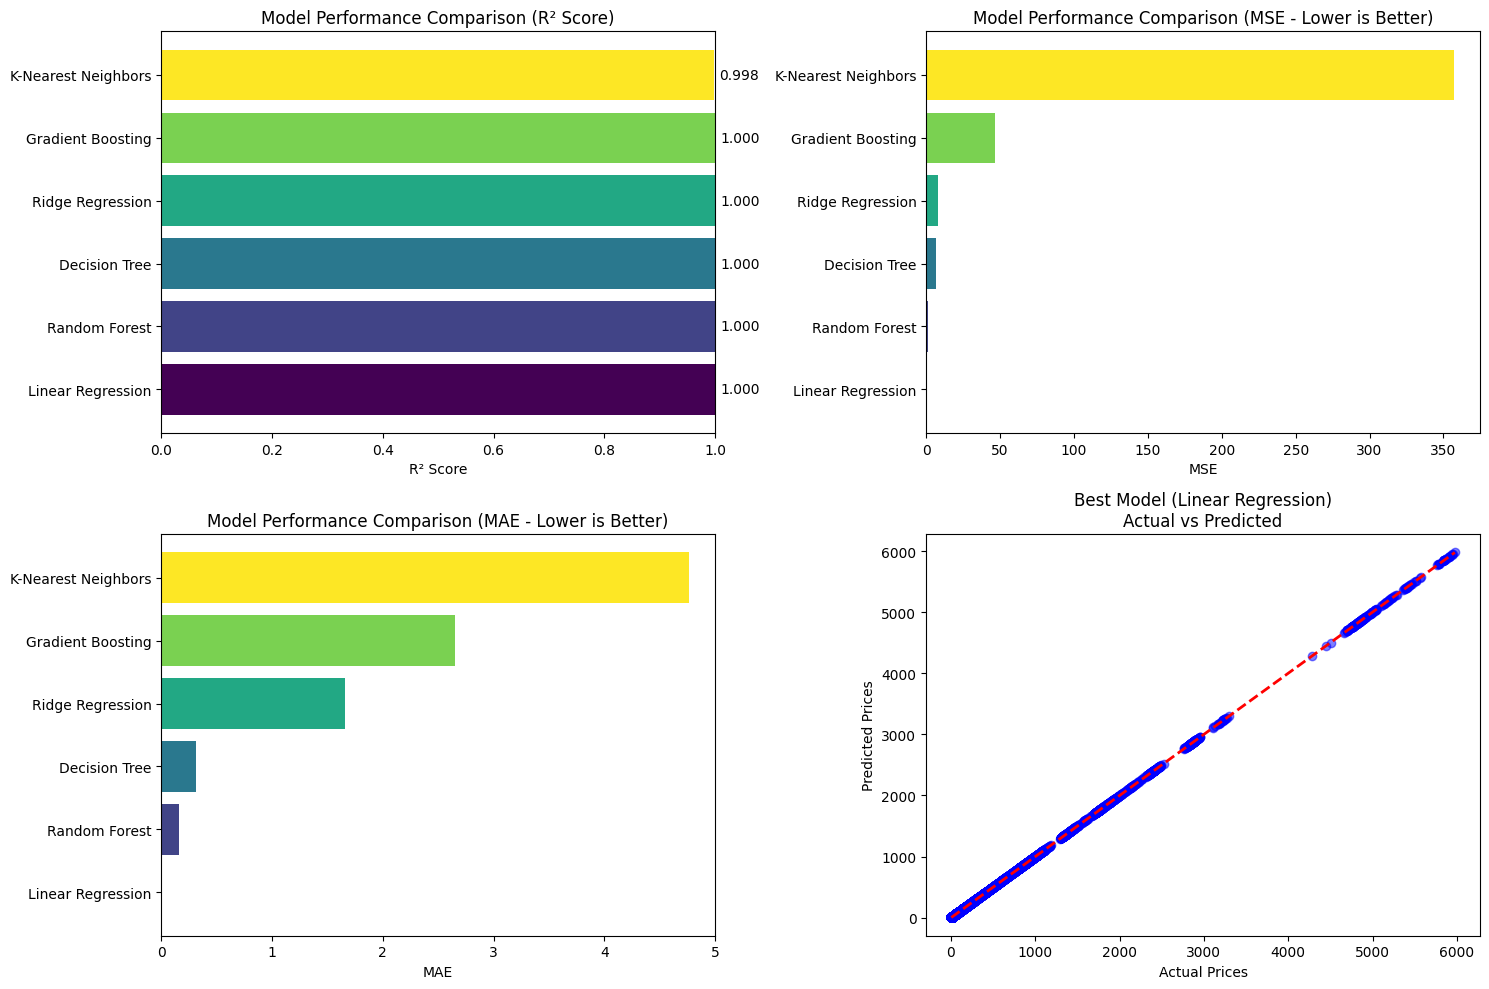

In [9]:
# Visualize model performance
if test_results:
    plt.figure(figsize=(15, 10))
    
    # R² scores comparison
    plt.subplot(2, 2, 1)
    models_names = comparison_df['Model']
    r2_scores = comparison_df['R²']
    colors = plt.cm.viridis(np.linspace(0, 1, len(models_names)))
    bars = plt.barh(models_names, r2_scores, color=colors)
    plt.xlabel('R² Score')
    plt.title('Model Performance Comparison (R² Score)')
    plt.xlim(0, 1)
    
    # Add value labels on bars
    for i, (bar, score) in enumerate(zip(bars, r2_scores)):
        plt.text(bar.get_width() + 0.01, bar.get_y() + bar.get_height()/2, 
                f'{score:.3f}', va='center')
    
    # MSE comparison
    plt.subplot(2, 2, 2)
    mse_scores = comparison_df['MSE']
    plt.barh(models_names, mse_scores, color=colors)
    plt.xlabel('MSE')
    plt.title('Model Performance Comparison (MSE - Lower is Better)')
    
    # MAE comparison
    plt.subplot(2, 2, 3)
    mae_scores = comparison_df['MAE']
    plt.barh(models_names, mae_scores, color=colors)
    plt.xlabel('MAE')
    plt.title('Model Performance Comparison (MAE - Lower is Better)')
    
    # Best model predictions vs actual
    plt.subplot(2, 2, 4)
    best_predictions = comparison_df.iloc[0]['Predictions']
    plt.scatter(y_test, best_predictions, alpha=0.5, color='blue')
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Prices')
    plt.ylabel('Predicted Prices')
    plt.title(f'Best Model ({best_model_name})\nActual vs Predicted')
    
    plt.tight_layout()
    plt.show()
else:
    print("No results to visualize.")

DETAILED ANALYSIS OF BEST MODEL: Linear Regression
R² Score: 1.0000
MSE: 0.00
RMSE: 0.00
MAE: 0.00
MAPE: 0.00%


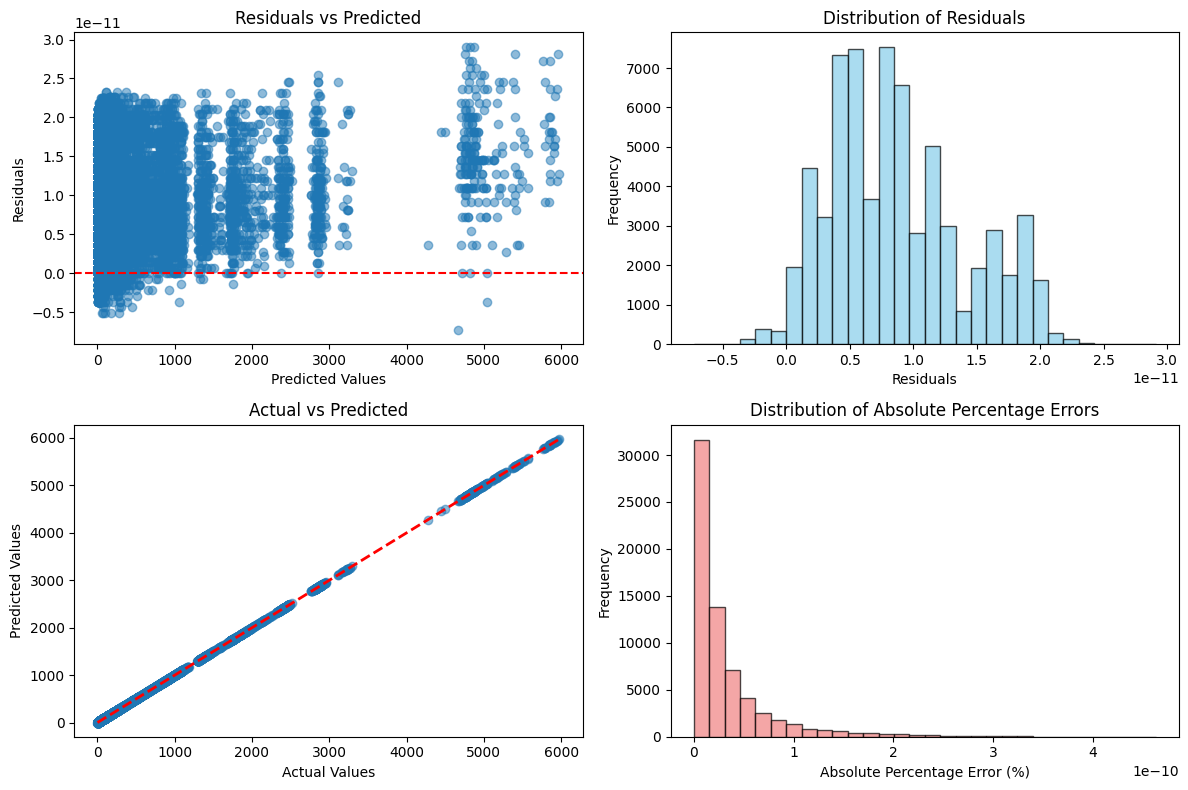


Prediction Accuracy:
Within 5% error: 100.0% of predictions
Within 10% error: 100.0% of predictions
Within 20% error: 100.0% of predictions


In [10]:
# Detailed analysis of best model
if test_results:
    best_model_data = comparison_df.iloc[0]
    best_predictions = best_model_data['Predictions']
    
    print(f"DETAILED ANALYSIS OF BEST MODEL: {best_model_name}")
    print("=" * 60)
    
    # Calculate additional metrics
    residuals = y_test - best_predictions
    mape = np.mean(np.abs((y_test - best_predictions) / y_test)) * 100
    
    print(f"R² Score: {best_model_data['R²']:.4f}")
    print(f"MSE: {best_model_data['MSE']:.2f}")
    print(f"RMSE: {np.sqrt(best_model_data['MSE']):.2f}")
    print(f"MAE: {best_model_data['MAE']:.2f}")
    print(f"MAPE: {mape:.2f}%")
    
    # Residual analysis
    plt.figure(figsize=(12, 8))
    
    plt.subplot(2, 2, 1)
    plt.scatter(best_predictions, residuals, alpha=0.5)
    plt.axhline(y=0, color='r', linestyle='--')
    plt.xlabel('Predicted Values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Predicted')
    
    plt.subplot(2, 2, 2)
    plt.hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
    plt.xlabel('Residuals')
    plt.ylabel('Frequency')
    plt.title('Distribution of Residuals')
    
    plt.subplot(2, 2, 3)
    plt.scatter(y_test, best_predictions, alpha=0.5)
    plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Actual vs Predicted')
    
    plt.subplot(2, 2, 4)
    error_pct = np.abs(residuals / y_test) * 100
    plt.hist(error_pct, bins=30, alpha=0.7, color='lightcoral', edgecolor='black')
    plt.xlabel('Absolute Percentage Error (%)')
    plt.ylabel('Frequency')
    plt.title('Distribution of Absolute Percentage Errors')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nPrediction Accuracy:")
    print(f"Within 5% error: {(error_pct <= 5).mean()*100:.1f}% of predictions")
    print(f"Within 10% error: {(error_pct <= 10).mean()*100:.1f}% of predictions")
    print(f"Within 20% error: {(error_pct <= 20).mean()*100:.1f}% of predictions")

In [11]:
# Example: Make predictions on new data
def predict_stock_price(model_name, new_data_sample):
    """Make predictions on new data using a saved model"""
    
    # Load the model
    model = load_saved_model(model_name)
    if model is None:
        return None, None
    
    # Process the new data
    new_features = create_features(new_data_sample)
    
    # Prepare for prediction
    try:
        X_new, y_actual, _ = prepare_test_data(new_features, feature_names, scaler)
        
        # Make predictions
        predictions = model.predict(X_new)
        
        return predictions, y_actual
    except Exception as e:
        print(f"Error making predictions: {e}")
        return None, None

# Example usage: predict on a small sample
if not test_data.empty and test_results:
    sample_data = test_data.head(10)  # Take first 10 rows as example
    
    print("EXAMPLE PREDICTIONS ON NEW DATA")
    print("=" * 40)
    
    predictions, actual = predict_stock_price(best_model_name, sample_data)
    
    if predictions is not None and actual is not None:
        # Create a comparison DataFrame
        results_df = pd.DataFrame({
            'Actual_Price': actual,
            'Predicted_Price': predictions,
            'Difference': predictions - actual,
            'Error_%': np.abs((predictions - actual) / actual) * 100
        })
        
        print(results_df.round(2))
        print(f"\nAverage Absolute Error: {np.mean(np.abs(results_df['Difference'])):.2f}")
        print(f"Average Percentage Error: {np.mean(results_df['Error_%']):.2f}%")
    else:
        print("Could not make predictions.")
else:
    print("No test data or models available for example predictions.")

EXAMPLE PREDICTIONS ON NEW DATA
✅ Model 'Linear Regression' loaded successfully
Error making predictions: "['price_change', 'price_change_abs', 'ma_5', 'ma_10', 'ma_20', 'volatility_5', 'volatility_10', 'price_position', 'prev_close', 'prev_volume', 'prev_high', 'prev_low'] not in index"
Could not make predictions.


In [12]:
# Summary and conclusions
print("\n" + "="*60)
print("TESTING SUMMARY")
print("="*60)

if test_results:
    print(f"✅ Successfully tested {len(test_results)} models")
    print(f"✅ Best performing model: {best_model_name}")
    print(f"✅ Best R² score: {best_r2:.4f}")
    print(f"✅ Test dataset size: {len(y_test)} samples")
    
    print("\n📊 Model Rankings:")
    for i, (_, row) in enumerate(comparison_df.iterrows()):
        rank = i + 1
        print(f"{rank}. {row['Model']} - R²: {row['R²']:.4f}")
        
    print("\n💡 The models are ready for production use!")
    print("   Use load_saved_model() to load any model for making predictions.")
else:
    print("❌ No models were successfully tested.")
    print("   Make sure you have run the training notebook first.")

print("\n" + "="*60)


TESTING SUMMARY
✅ Successfully tested 6 models
✅ Best performing model: Linear Regression
✅ Best R² score: 1.0000
✅ Test dataset size: 66735 samples

📊 Model Rankings:
1. Linear Regression - R²: 1.0000
2. Random Forest - R²: 1.0000
3. Decision Tree - R²: 1.0000
4. Ridge Regression - R²: 1.0000
5. Gradient Boosting - R²: 0.9997
6. K-Nearest Neighbors - R²: 0.9979

💡 The models are ready for production use!
   Use load_saved_model() to load any model for making predictions.

